In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/stock-market-data
!unzip stock-market-data.zip


Streaming output truncated to the last 5000 lines.
  inflating: stock_market_data/nasdaq/json/CLNT.json  
  inflating: stock_market_data/nasdaq/json/CLRB.json  
  inflating: stock_market_data/nasdaq/json/CLRI.json  
  inflating: stock_market_data/nasdaq/json/CLRO.json  
  inflating: stock_market_data/nasdaq/json/CLRX.json  
  inflating: stock_market_data/nasdaq/json/CLTX.json  
  inflating: stock_market_data/nasdaq/json/CLVS.json  
  inflating: stock_market_data/nasdaq/json/CLWT.json  
  inflating: stock_market_data/nasdaq/json/CLYAF.json  
  inflating: stock_market_data/nasdaq/json/CMCO.json  
  inflating: stock_market_data/nasdaq/json/CMCSA.json  
  inflating: stock_market_data/nasdaq/json/CMCT.json  
  inflating: stock_market_data/nasdaq/json/CME.json  
  inflating: stock_market_data/nasdaq/json/CMGE.json  
  inflating: stock_market_data/nasdaq/json/CMLS.json  
  inflating: stock_market_data/nasdaq/json/CMOXF.json  
  inflating: stock_market_data/nasdaq/json/CMPR.json  
  inflating:

INSTALL REQUIRED LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN

In [ ]:
!ls -R

.:
sample_data  stock_market_data	stock-market-data.zip

./sample_data:
anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md

./stock_market_data:
forbes2000  nasdaq  nyse  sp500

./stock_market_data/forbes2000:
csv  json

./stock_market_data/forbes2000/csv:
AAALY.csv  BCKIY.csv  CLPBY.csv  ESYJY.csv  HUM.csv    MAEOY.csv  OTSKY.csv  SFOSF.csv	TRGNF.csv
AACAY.csv  BCMXY.csv  CLPXY.csv  EUZOF.csv  HXGBY.csv  MAHMF.csv  OVCHF.csv  SGBLY.csv	TRGP.csv
AAL.csv    BCS.csv    CLR.csv	 EWBC.csv   HYKUF.csv  MAKSY.csv  OXY.csv    SGDBF.csv	TRI.csv
AAP.csv    BDORY.csv  CMCLF.csv  EW.csv     HYMTF.csv  MAN.csv	  PACW.csv   SGFEF.csv	TROW.csv
AAPL.csv   BDOUY.csv  CM.csv	 EXPE.csv   HYUHF.csv  MAR.csv	  PAG.csv    SGHIY.csv	TRYIY.csv
ABBV.csv   BDRBF.csv  CME.csv	 EXPGY.csv  IAUGY.csv  MAT.csv	  PAYX.csv   SGSOF.csv	TSCDY.csv
ABC.csv    BDX.csv    CMGGF.csv  EXR.csv    IBDRY.csv  MCD.csv	  PBA.csv    SHASF.csv	TSCO.csv
A

In [ ]:
df = pd.read_csv('./stock_market_data/nyse/csv/IBM.csv')
print(df.head())

         Date        Low       Open  Volume       High      Close  \
0  02-01-1970  17.399618  17.423517  330536  17.483271  17.435469   
1  05-01-1970  17.495220  17.495220  443504  17.602772  17.602772   
2  06-01-1970  17.507170  17.602772  510448  17.638622  17.614723   
3  07-01-1970  17.507170  17.614723  479068  17.626673  17.626673   
4  08-01-1970  17.566921  17.626673  740568  17.662523  17.662523   

   Adjusted Close  
0        3.820174  
1        3.856834  
2        3.859450  
3        3.862067  
4        3.869923  


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')
features = ['High', 'Low', 'Volume', 'Close']
data = df[features]

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

data_scaled = pd.DataFrame(data_scaled, columns=features)
data_scaled['Date'] = df['Date']
data_scaled.set_index('Date', inplace=True)

In [ ]:
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(data_scaled.values, time_steps)

DATA SPLITTING

In [ ]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


BUILD AND TRAIN MODEL

In [ ]:
def build_and_train_model(model_type, X_train, y_train, X_val, y_val, time_steps, num_features):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(50, input_shape=(time_steps, num_features), activation='relu'))
    elif model_type == 'GRU':
        model.add(GRU(50, input_shape=(time_steps, num_features), activation='relu'))
    elif model_type == 'LSTM':
        model.add(LSTM(50, input_shape=(time_steps, num_features), activation='relu'))
    model.add(Dense(1))  # Predicting the 'Close' price
    model.compile(optimizer='adam', loss='mse')
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        #callbacks=[early_stopping],
        verbose=1
    )
    return model, history

num_features = X_train.shape[2]
rnn_model, rnn_history = build_and_train_model('RNN', X_train, y_train, X_val, y_val, time_steps, num_features)
gru_model, gru_history = build_and_train_model('GRU', X_train, y_train, X_val, y_val, time_steps, num_features)
lstm_model, lstm_history = build_and_train_model('LSTM', X_train, y_train, X_val, y_val, time_steps, num_features)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0026 - val_loss: 3.0825e-04
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7838e-05 - val_loss: 2.5196e-04
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.1102e-05 - val_loss: 1.9091e-04
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8697e-05 - val_loss: 3.4615e-04
Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.8456e-05 - val_loss: 1.4625e-04
Epoch 6/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.6492e-05 - val_loss: 1.4414e-04
Epoch 7/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.8715e-05 - val_loss: 1.3551e-04
Epoch 8/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.2825e-05 - val_loss: 1.5904e-04
Epoch 9/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.5445e-05 - val_loss: 1.5709e-04
Epoch 10/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7357e-05 - val_loss: 1.2237e-04
Epoch 11/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 

Predict the next day's 'Close' price

In [ ]:
def predict_next_day(model, data_scaled, scaler, time_steps=30):
    last_sequence = data_scaled.values[-time_steps:, :-1]
    last_sequence = last_sequence.reshape((1, time_steps, last_sequence.shape[1]))


    next_day_scaled = model.predict(last_sequence)
    next_day_price = scaler.inverse_transform(
        np.concatenate([np.zeros((1, data_scaled.shape[1] - 1)), next_day_scaled], axis=1)
    )[:, -1]

    return next_day_price[0]

next_day_rnn = predict_next_day(rnn_model, data_scaled, scaler)
print(f"Predicted Next Day Price (RNN): {next_day_rnn:.2f} \n")

next_day_gru = predict_next_day(gru_model, data_scaled, scaler)
print(f"Predicted Next Day Price (GRU): {next_day_gru:.2f} \n")

next_day_lstm = predict_next_day(lstm_model, data_scaled, scaler)
print(f"Predicted Next Day Price (LSTM): {next_day_lstm:.2f} \n")

# actual price for the next day
def get_actual_next_day_price(y_test, scaler):
    actual_price_scaled = y_test[0].reshape(-1, 1)
    actual_price = scaler.inverse_transform(
        np.concatenate([np.zeros((1, data_scaled.shape[1] - 1)), actual_price_scaled], axis=1)
    )[:, -1]
    return actual_price[0]

actual_next_day_price = get_actual_next_day_price(y_test, scaler)
print(f"Actual Next Day Price: {actual_next_day_price:.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Predicted Next Day Price (RNN): 145.47 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
Predicted Next Day Price (GRU): 145.20 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Predicted Next Day Price (LSTM): 147.27 

Actual Next Day Price: 152.50


EVALUATOIN AND VISUALIZATIONS

In [ ]:
def evaluate_model(model, X_test, y_test, scaler, num_features):
    predictions_scaled = model.predict(X_test)

    # dummy colmns are needed to stop shape erors
    dummy_columns = np.zeros((len(predictions_scaled), num_features - 1))
    predictions_full = np.concatenate([dummy_columns, predictions_scaled], axis=1)
    predictions_rescaled = scaler.inverse_transform(predictions_full)[:, -1]
    y_test_full = np.concatenate([dummy_columns, y_test.reshape(-1, 1)], axis=1)
    y_test_rescaled = scaler.inverse_transform(y_test_full)[:, -1]

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

    return predictions_rescaled, rmse, mae, mape


num_features = X_test.shape[2] + 1

# Evaluate RNN Model
rnn_predictions, rnn_rmse, rnn_mae, rnn_mape = evaluate_model(rnn_model, X_test, y_test, scaler, num_features)
print(f"RNN Metrics: RMSE = {rnn_rmse:.2f}, MAE = {rnn_mae:.2f}, MAPE = {rnn_mape:.2f}%")

# Evaluate GRU Model
gru_predictions, gru_rmse, gru_mae, gru_mape = evaluate_model(gru_model, X_test, y_test, scaler, num_features)
print(f"GRU Metrics: RMSE = {gru_rmse:.2f}, MAE = {gru_mae:.2f}, MAPE = {gru_mape:.2f}%")

# Evaluate LSTM Model
lstm_predictions, lstm_rmse, lstm_mae, lstm_mape = evaluate_model(lstm_model, X_test, y_test, scaler, num_features)
print(f"LSTM Metrics: RMSE = {lstm_rmse:.2f}, MAE = {lstm_mae:.2f}, MAPE = {lstm_mape:.2f}%")



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RNN Metrics: RMSE = 2.46, MAE = 1.87, MAPE = 1.39%
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
GRU Metrics: RMSE = 2.59, MAE = 2.03, MAPE = 1.49%
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
LSTM Metrics: RMSE = 2.19, MAE = 1.53, MAPE = 1.15%


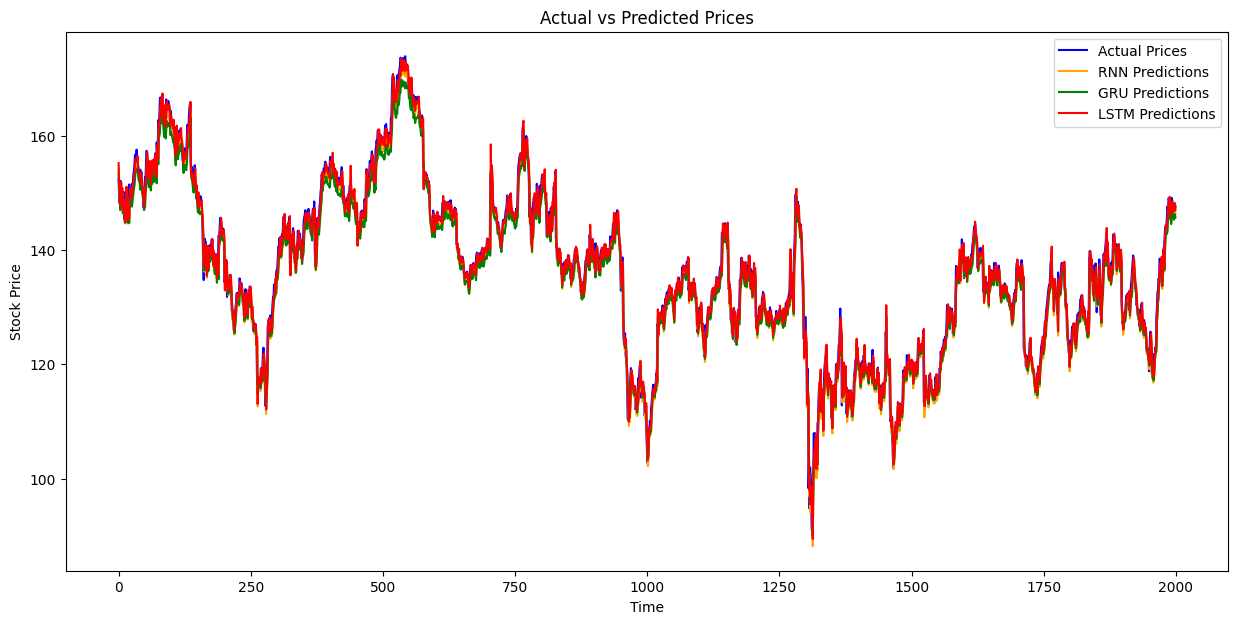

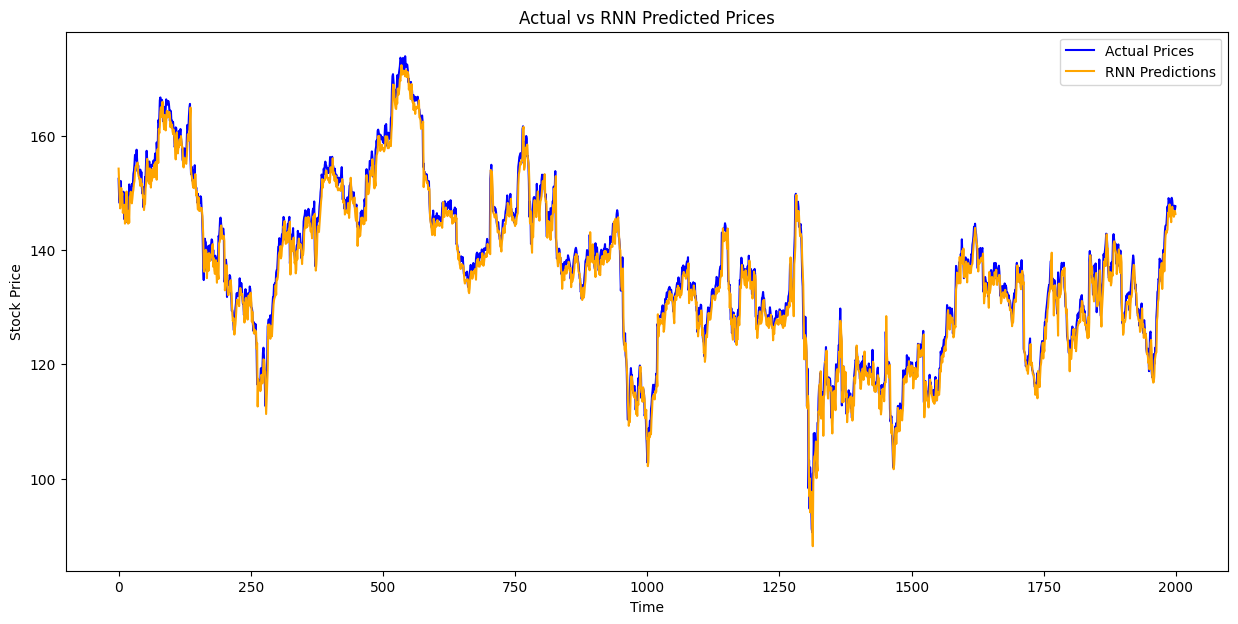

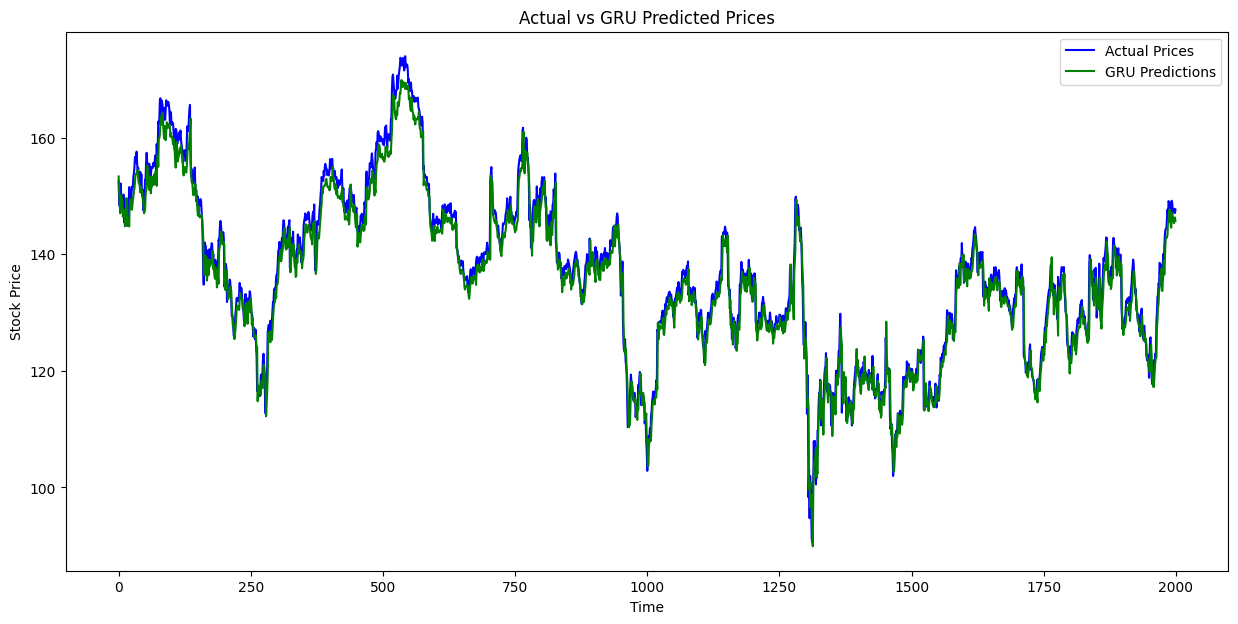

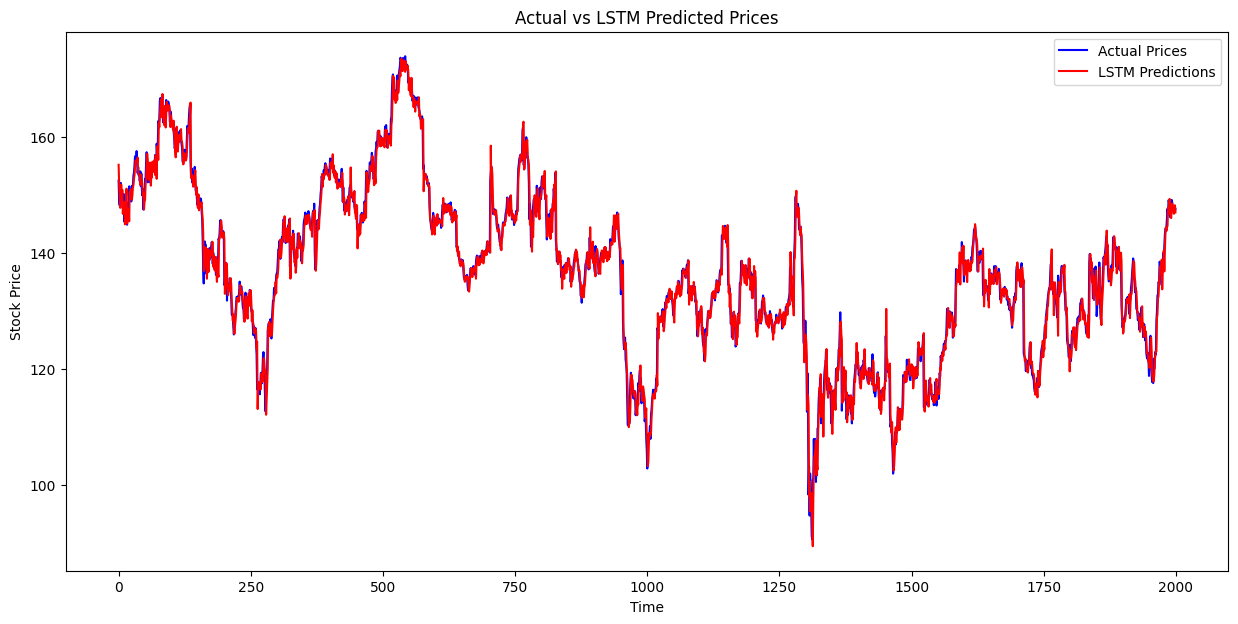

In [ ]:

dummy_columns = np.zeros((len(y_test), num_features - 1))
y_test_full = np.concatenate([dummy_columns, y_test.reshape(-1, 1)], axis=1)
y_test_rescaled = scaler.inverse_transform(y_test_full)[:, -1]

plt.figure(figsize=(15, 7))
plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(rnn_predictions, label='RNN Predictions', color='orange')
plt.plot(gru_predictions, label='GRU Predictions', color='green')
plt.plot(lstm_predictions, label='LSTM Predictions', color='red')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

# Actual vs RNN Predictions
plt.figure(figsize=(15, 7))
plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(rnn_predictions, label='RNN Predictions', color='orange')
plt.legend()
plt.title('Actual vs RNN Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

# Actual vs GRU Predictions
plt.figure(figsize=(15, 7))
plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(gru_predictions, label='GRU Predictions', color='green')
plt.legend()
plt.title('Actual vs GRU Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

# Actual vs LSTM Predictions
plt.figure(figsize=(15, 7))
plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(lstm_predictions, label='LSTM Predictions', color='red')
plt.legend()
plt.title('Actual vs LSTM Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()



In [ ]:

last_30_days_scaled = data_scaled.values[-30:]
last_30_days_original = scaler.inverse_transform(last_30_days_scaled)

np.set_printoptions(suppress=True, precision=2)
closing_prices_scaled = last_30_days_scaled[:, -1]
closing_prices_original = last_30_days_original[:, -1]

print("Last 30 Days Used for Prediction (Scaled): \n", closing_prices_scaled)
print("Last 30 Days Closing Prices (Original): \n", closing_prices_original)



Last 30 Days Used for Prediction (Scaled): 
 [0.66 0.65 0.65 0.64 0.65 0.66 0.66 0.65 0.67 0.68 0.69 0.69 0.69 0.69
 0.7  0.7  0.71 0.71 0.71 0.7  0.7  0.71 0.71 0.71 0.7  0.7  0.7  0.7
 0.7  0.7 ]
Last 30 Days Closing Prices (Original): 
 [138.29 138.2  136.83 134.47 136.96 138.34 140.04 137.39 141.23 143.17
 144.2  144.34 144.52 146.09 147.64 146.68 149.1  148.75 148.37 146.18
 146.49 148.9  149.16 148.67 147.41 147.5  147.27 147.78 147.05 147.65]


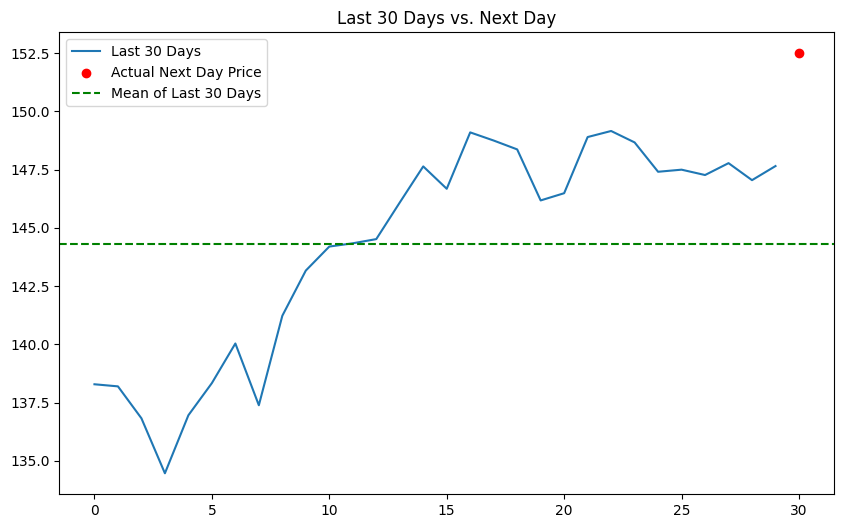

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'].values[-30:], label="Last 30 Days")
plt.scatter(30, actual_next_day_price, color='red', label="Actual Next Day Price")
plt.axhline(y=np.mean(data['Close'].values[-30:]), color='green', linestyle='--', label="Mean of Last 30 Days")
plt.legend()
plt.title("Last 30 Days vs. Next Day")
plt.show()